MA Crossover signals: 38
RSI signals: 69
MACD Condition 1 signals: 17
MACD Condition 2 signals: 40


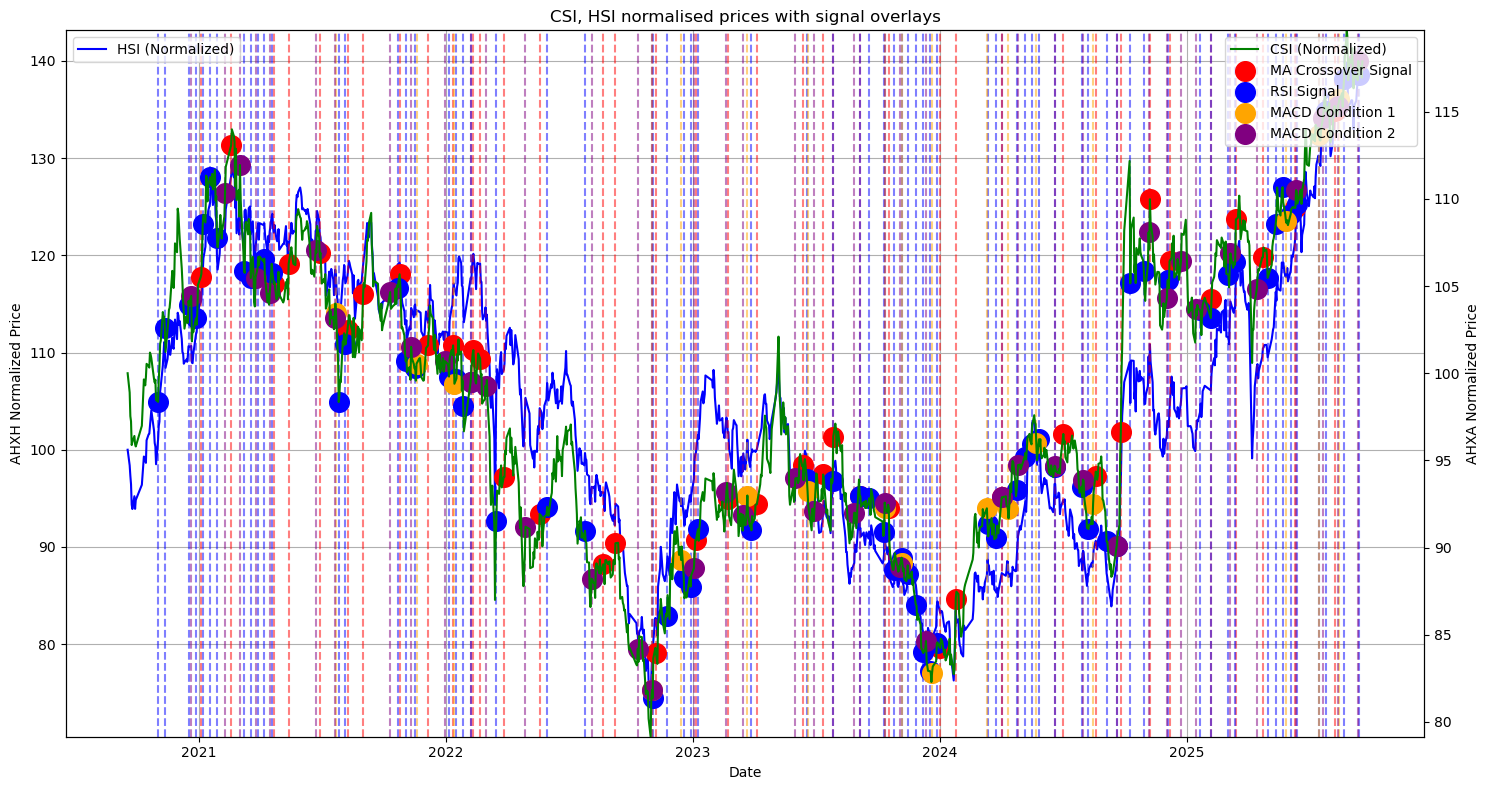

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "CSI HSI Data.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")
df.columns = df.columns.str.strip()
df = df.dropna(subset=["AHXH Index", "AHXA Index"])
df.rename(columns={
    "AHXH Index": "AHXH",
    "AHXA Index": "AHXA"
}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

# normalising prices for plotting
normalized_prices = df[["AHXH", "AHXA"]] / df[["AHXH", "AHXA"]].iloc[0] * 100
normalized_prices.columns = ["HSI", "CSI"]

# calculating RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_ahxh = compute_rsi(df["AHXH"])
rsi_ahxa = compute_rsi(df["AHXA"])

# calculating MACD
def compute_macd_lines(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, min_periods=fast).mean()
    ema_slow = series.ewm(span=slow, min_periods=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=signal).mean()
    return macd_line, signal_line

macd_line_ahxh, signal_line_ahxh = compute_macd_lines(df["AHXH"])
macd_line_ahxa, signal_line_ahxa = compute_macd_lines(df["AHXA"])

#5-day MA and 20-day MA
ma_5 = df["AHXA"].rolling(window=5).mean()
ma_20 = df["AHXA"].rolling(window=20).mean()

ma_crossover_signal = pd.Series(0, index=df.index)
last_ma_trigger = df.index[0] - pd.Timedelta(days=10)

for i in range(1, len(df)):
    date = df.index[i]
    if (
        ma_5.iloc[i] > ma_20.iloc[i] and
        ma_5.iloc[i-1] <= ma_20.iloc[i-1] and
        (date - last_ma_trigger).days >= 10
    ):
        ma_crossover_signal.iloc[i] = 1
        last_ma_trigger = date

# RSI signal
rsi_signal_raw = ((rsi_ahxh - rsi_ahxa) > 5).astype(int)
rsi_signal = pd.Series(0, index=rsi_signal_raw.index)
min_rsi_gap = 10
last_rsi_trigger = rsi_signal_raw.index[0] - pd.Timedelta(days=min_rsi_gap)

for date in rsi_signal_raw.index:
    if rsi_signal_raw.loc[date] == 1 and (date - last_rsi_trigger).days >= min_rsi_gap:
        rsi_signal.loc[date] = 1
        last_rsi_trigger = date

# MACD conditions (based on signal line and MACD line)
threshold_pct = 0.05
condition_1_signal = pd.Series(0, index=df.index)
condition_2_signal = pd.Series(0, index=df.index)
last_trigger_1 = df.index[0] - pd.Timedelta(days=11)
last_trigger_2 = df.index[0] - pd.Timedelta(days=11)

for i in range(35, len(df)):
    date = df.index[i]

    # MACD condition 1
    cond_1a = macd_line_ahxh.iloc[i] > signal_line_ahxh.iloc[i]
    diff_ahxa = signal_line_ahxa.iloc[i] - macd_line_ahxa.iloc[i]
    cond_1b = (
        macd_line_ahxa.iloc[i] < signal_line_ahxa.iloc[i] and
        diff_ahxa / abs(signal_line_ahxa.iloc[i]) < threshold_pct
    )
    if cond_1a and cond_1b and (date - last_trigger_1).days > 20:
        condition_1_signal.iloc[i] = 1
        last_trigger_1 = date

    # MACD condition 2
    prev_diff_ahxh = macd_line_ahxh.iloc[i-1] - signal_line_ahxh.iloc[i-1]
    curr_diff_ahxh = macd_line_ahxh.iloc[i] - signal_line_ahxh.iloc[i]
    cond_2a = curr_diff_ahxh > prev_diff_ahxh
    slope_ahxa = macd_line_ahxa.iloc[i] - macd_line_ahxa.iloc[i-1]
    cond_2b = slope_ahxa > 0 and macd_line_ahxa.iloc[i] < signal_line_ahxa.iloc[i]

    if cond_2a and cond_2b and (date - last_trigger_2).days > 20:
        condition_2_signal.iloc[i] = 1
        last_trigger_2 = date

# plotting graph
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.plot(normalized_prices.index, normalized_prices['HSI'], label='HSI (Normalized)', color='blue')
ax2 = ax1.twinx()
ax2.plot(normalized_prices.index, normalized_prices['CSI'], label='CSI (Normalized)', color='green')
ax2.set_ylim(normalized_prices['CSI'].min(), normalized_prices['CSI'].max())

def overlay_signals(signal_series, color, label):
    signal_dates = signal_series[signal_series == 1].index
    ax2.scatter(signal_dates, normalized_prices.loc[signal_dates, 'CSI'],
                color=color, label=label, marker='o', s=200)
    for date in signal_dates:
        ax1.axvline(x=date, color=color, linestyle='--', alpha=0.5)

overlay_signals(ma_crossover_signal, 'red', 'MA Crossover Signal')
overlay_signals(rsi_signal, 'blue', 'RSI Signal')
overlay_signals(condition_1_signal, 'orange', 'MACD Condition 1')
overlay_signals(condition_2_signal, 'purple', 'MACD Condition 2')

plt.title("CSI, HSI normalised prices with signal overlays")
ax1.set_xlabel("Date")
ax1.set_ylabel("AHXH Normalized Price")
ax2.set_ylabel("AHXA Normalized Price")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)
fig.tight_layout()

print("MA Crossover signals:", ma_crossover_signal.sum())
print("RSI signals:", rsi_signal.sum())
print("MACD Condition 1 signals:", condition_1_signal.sum())
print("MACD Condition 2 signals:", condition_2_signal.sum())

plt.show()


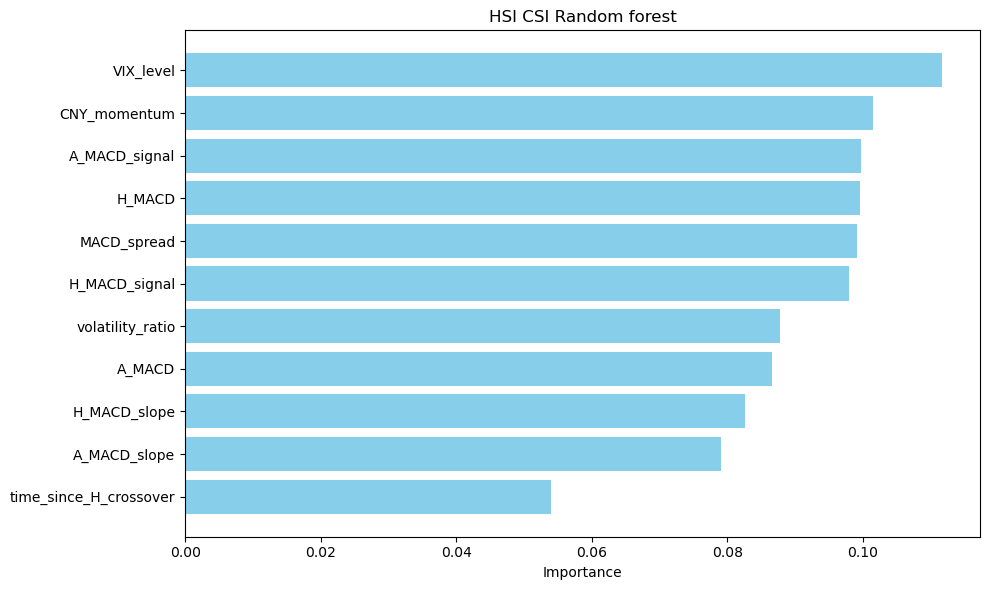

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.52      0.57       149
         1.0       0.34      0.47      0.39        79

    accuracy                           0.50       228
   macro avg       0.49      0.49      0.48       228
weighted avg       0.54      0.50      0.51       228



In [3]:
# using random forest for feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

vix_cny_path = "CSI HSI Data.xlsx"
vix_cny_df = pd.read_excel(vix_cny_path, engine="openpyxl")
vix_cny_df.columns = vix_cny_df.columns.str.strip()

vix_cny_df["Date"] = pd.to_datetime(vix_cny_df["Date"])
vix_cny_df.set_index("Date", inplace=True)
vix_cny_df.rename(columns={
    "VHSI Index": "VHX",
    "CNH BGN Curncy": "CNH"
}, inplace=True)

common_dates = df.index.intersection(vix_cny_df.index)
df = df.loc[common_dates]
vix_cny_df = vix_cny_df.loc[common_dates]
normalized_prices = normalized_prices.loc[common_dates]

# feature engineering
features_df = pd.DataFrame(index=df.index)

features_df['H_MACD'] = macd_line_ahxh.loc[common_dates]
features_df['A_MACD'] = macd_line_ahxa.loc[common_dates]
features_df['H_MACD_signal'] = signal_line_ahxh.loc[common_dates]
features_df['A_MACD_signal'] = signal_line_ahxa.loc[common_dates]
features_df['H_MACD_slope'] = macd_line_ahxh.diff().loc[common_dates]
features_df['A_MACD_slope'] = macd_line_ahxa.diff().loc[common_dates]
features_df['MACD_spread'] = macd_line_ahxh.loc[common_dates] - macd_line_ahxa.loc[common_dates]

h_crossover = (macd_line_ahxh > signal_line_ahxh).astype(int).loc[common_dates]
features_df['time_since_H_crossover'] = (
    h_crossover * (h_crossover.groupby((h_crossover != h_crossover.shift()).cumsum()).cumcount() + 1)
).fillna(0)

features_df['CNY_momentum'] = vix_cny_df['CNH'].pct_change(periods=5)
features_df['VIX_level'] = vix_cny_df['VHX']
features_df['volatility_ratio'] = vix_cny_df['VHX'] / vix_cny_df['VHX'].rolling(window=5).mean()

# target variable is whether CSI outperforms HSI over next 5 days
csi_return = normalized_prices['CSI'].pct_change(periods=5)
hsi_return = normalized_prices['HSI'].pct_change(periods=5)
target = (csi_return > hsi_return).astype(int).shift(-5)

model_df = features_df.copy()
model_df['target'] = target
model_df.dropna(inplace=True)


X = model_df.drop(columns='target')
y = model_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# fitting the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
model_df.loc[X_test.index, 'rf_signal'] = rf_predictions

importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('HSI CSI Random forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

In [4]:
def generate_performance_summary(returns: pd.Series, trades: list, positions: pd.Series = None):
    annual_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility else np.nan
    expon_sharpe = (
        returns.ewm(span=60).mean() / returns.ewm(span=60).std()
    ).mean() * np.sqrt(252)

    trade_returns = [t['return'] for t in trades]
    trade_sharpe = (
        np.mean(trade_returns) / np.std(trade_returns)
        if len(trade_returns) > 1 and np.std(trade_returns) > 0
        else np.nan
    )

# long sharpe
    long_sharpe = np.nan
    if positions is not None:
        long_returns = returns[positions > 0]
        if len(long_returns) > 1 and long_returns.std() > 0:
            long_sharpe = long_returns.mean() / long_returns.std() * np.sqrt(252)

# sortino
    downside = returns[returns < 0]
    sortino = returns.mean() / downside.std() * np.sqrt(252) if downside.std() else np.nan

# omega
    threshold = 0
    gain = (returns[returns > threshold] - threshold).sum()
    loss = (threshold - returns[returns < threshold]).sum()
    omega = gain / loss if loss else np.nan

# hit rates, holding periods
    long_trades = [t for t in trades if t['side'] == 'long']
    short_trades = [t for t in trades if t['side'] == 'short']
    avg_long_holding_period = np.mean([
        (t['exit_date'] - t['entry_date']).days for t in long_trades
    ]) if long_trades else np.nan
    avg_short_holding_period = np.mean([
        (t['exit_date'] - t['entry_date']).days for t in short_trades
    ]) if short_trades else np.nan
    long_hits = sum(t['return'] > 0 for t in long_trades)
    short_hits = sum(t['return'] > 0 for t in short_trades)
    long_hitrate = long_hits / len(long_trades) if long_trades else np.nan
    short_hitrate = short_hits / len(short_trades) if short_trades else np.nan

    overall_hitrate = (
        sum(t['return'] > 0 for t in trades) / len(trades)
        if trades else np.nan
    )
    total_days = (returns.index[-1] - returns.index[0]).days
    years = total_days / 365.25
    avg_trades_per_year = len(trades) / years if years > 0 else np.nan

# drawdowns
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = cum_returns / rolling_max - 1

    max_drawdown = drawdowns.min()
    end_date = drawdowns.idxmin()
    start_date = cum_returns.loc[:end_date].idxmax()
    drawdown_period = f"{start_date.strftime('%d-%b-%y')} to {end_date.strftime('%d-%b-%y')} ({(end_date - start_date).days} days)"

    ann_return_to_drawdown = (
        annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    )

    pct_positive_days = (returns > 0).mean() * 100
    max_losing_streak = 0
    streak = 0
    for r in returns:
        if r < 0:
            streak += 1
            max_losing_streak = max(max_losing_streak, streak)
        else:
            streak = 0
# results function
    results = {
        'annual_return': annual_return,
        'sharpe': sharpe,
        'expon_sharpe': expon_sharpe,
        'trade_sharpe': trade_sharpe,
        'long_sharpe': long_sharpe,
        'sortino': sortino,
        'omega': omega,
        'avg_long_holding_period': avg_long_holding_period,
        'long_hits': len(long_trades),
        'long_hitrate': long_hitrate,
        'avg_short_holding_period': avg_short_holding_period,
        'short_hits': len(short_trades),
        'short_hitrate': short_hitrate,
        'avg_trades_per_year': avg_trades_per_year,
        'overall_hitrate': overall_hitrate,
        'max_drawdown': max_drawdown,
        'max_drawdown_period': drawdown_period,
        'ann_return_to_drawdown': ann_return_to_drawdown,
        'pct_positive_days': pct_positive_days,
        'max_losing_streak': max_losing_streak
    }

    return pd.DataFrame(results, index=["CSI/HSI"])

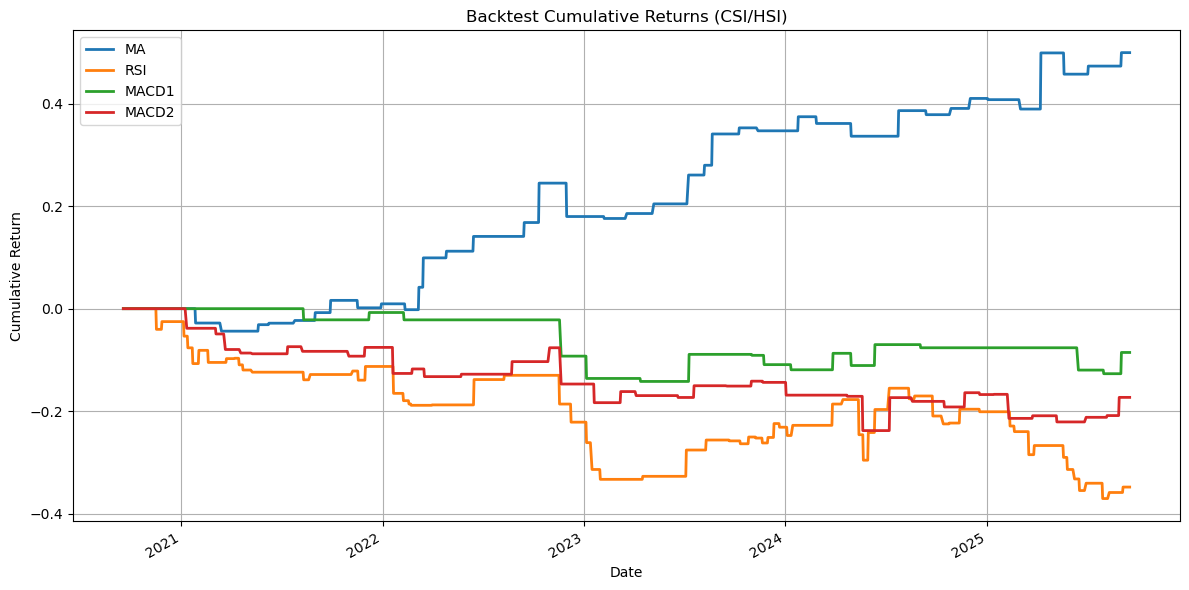

,MA,RSI,MACD1,MACD2
annual_return,0.107799,-0.077222,-0.020103,-0.039523
sharpe,1.074137,-0.732556,-0.323031,-0.501816
expon_sharpe,0.967406,-0.650812,-0.463894,-0.433737
trade_sharpe,0.402754,-0.188774,-0.156299,-0.165337
long_sharpe,18.597294,19.677566,40.22526,18.375327
sortino,0.385876,-0.277139,-0.056121,-0.10967
omega,2.977124,0.624395,0.679911,0.630828
avg_long_holding_period,23.342105,15.705882,18.411765,18.717949
long_hits,38,68,17,39
long_hitrate,0.657895,0.426471,0.294118,0.410256


Correlation with CSI returns:
MA:     0.048
RSI:    -0.030
MACD1:  0.024
MACD2:  -0.031


In [5]:
# testing for a 5y horizon
# using CSI/HSI to find the differential of CSI vs HSI, ie the relative outperformance

ratio_prices = normalized_prices['CSI'] / normalized_prices['HSI']

def run_signal_backtest(signal_series, price_series, lag=0, holding_period=15, label='signal'):
    signal = signal_series.shift(lag).fillna(0).astype(int)
    signal = signal.loc[price_series.index]

    returns = pd.Series(0, index=price_series.index, dtype=float)
    trades = []

    for date in signal.index:
        if signal.loc[date] == 1:
            entry_date = date
            try:
                exit_idx = signal.index.get_loc(entry_date) + holding_period
                if exit_idx >= len(price_series):
                    continue
                exit_date = signal.index[exit_idx]
                entry_price = price_series.loc[entry_date]
                exit_price = price_series.loc[exit_date]
                ret = exit_price / entry_price - 1
                returns.loc[exit_date] += ret
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'return': ret,
                    'side': 'long'
                })
            except Exception:
                continue

    return returns, trades

# backtesting with variable lags, holding periods
ma_returns, ma_trades = run_signal_backtest(
    signal_series=ma_crossover_signal,
    price_series=ratio_prices,
    lag=2,
    holding_period=15,
    label='MA'
)

rsi_returns, rsi_trades = run_signal_backtest(
    signal_series=rsi_signal,
    price_series=ratio_prices,
    lag=1,
    holding_period=10,
    label='RSI'
)

macd1_returns, macd1_trades = run_signal_backtest(
    signal_series=condition_1_signal,
    price_series=ratio_prices,
    lag=1,
    holding_period=12,
    label='MACD1'
)

macd2_returns, macd2_trades = run_signal_backtest(
    signal_series=condition_2_signal,
    price_series=ratio_prices,
    lag=1,
    holding_period=12,
    label='MACD2'
)

plt.figure(figsize=(12, 6))
ma_returns.cumsum().plot(label='MA', lw=2)
rsi_returns.cumsum().plot(label='RSI', lw=2)
macd1_returns.cumsum().plot(label='MACD1', lw=2)
macd2_returns.cumsum().plot(label='MACD2', lw=2)
plt.title("Backtest Cumulative Returns (CSI/HSI)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def generate_performance_summary(returns: pd.Series, trades: list, positions: pd.Series = None):
    annual_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility else np.nan
    expon_sharpe = (
        returns.ewm(span=60).mean() / returns.ewm(span=60).std()
    ).mean() * np.sqrt(252)

    trade_returns = [t['return'] for t in trades]
    trade_sharpe = np.mean(trade_returns) / np.std(trade_returns) if len(trade_returns) > 1 and np.std(trade_returns) > 0 else np.nan

    long_returns = returns[returns > 0]
    long_sharpe = long_returns.mean() / long_returns.std() * np.sqrt(252) if len(long_returns) > 1 and long_returns.std() > 0 else np.nan

    downside = returns[returns < 0]
    sortino = returns.mean() / downside.std() * np.sqrt(252) if downside.std() else np.nan

    threshold = 0
    gain = (returns[returns > threshold] - threshold).sum()
    loss = (threshold - returns[returns < threshold]).sum()
    omega = gain / loss if loss else np.nan

    long_trades = [t for t in trades if t['side'] == 'long']
    avg_long_holding_period = np.mean([(t['exit_date'] - t['entry_date']).days for t in long_trades]) if long_trades else np.nan
    long_hits = sum(t['return'] > 0 for t in long_trades)
    long_hitrate = long_hits / len(long_trades) if long_trades else np.nan

    total_days = (returns.index[-1] - returns.index[0]).days
    years = total_days / 365.25
    avg_trades_per_year = len(trades) / years if years > 0 else np.nan
    overall_hitrate = sum(t['return'] > 0 for t in trades) / len(trades) if trades else np.nan

    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = cum_returns / rolling_max - 1
    max_drawdown = drawdowns.min()
    end_date = drawdowns.idxmin()
    start_date = cum_returns.loc[:end_date].idxmax()
    drawdown_period = f"{start_date.strftime('%d-%b-%y')} to {end_date.strftime('%d-%b-%y')} ({(end_date - start_date).days} days)"
    ann_return_to_drawdown = annual_return / abs(max_drawdown) if max_drawdown else np.nan
    pct_positive_days = (returns > 0).mean() * 100

    max_losing_streak = 0
    streak = 0
    for r in returns:
        if r < 0:
            streak += 1
            max_losing_streak = max(max_losing_streak, streak)
        else:
            streak = 0

    results = {
        'annual_return': annual_return,
        'sharpe': sharpe,
        'expon_sharpe': expon_sharpe,
        'trade_sharpe': trade_sharpe,
        'long_sharpe': long_sharpe,
        'sortino': sortino,
        'omega': omega,
        'avg_long_holding_period': avg_long_holding_period,
        'long_hits': len(long_trades),
        'long_hitrate': long_hitrate,
        'avg_trades_per_year': avg_trades_per_year,
        'overall_hitrate': overall_hitrate,
        'max_drawdown': max_drawdown,
        'max_drawdown_period': drawdown_period,
        'ann_return_to_drawdown': ann_return_to_drawdown,
        'pct_positive_days': pct_positive_days,
        'max_losing_streak': max_losing_streak
    }

    return pd.DataFrame(results, index=["CSI/HSI"])

summary_ma = generate_performance_summary(ma_returns, ma_trades).rename(index={"CSI/HSI": "MA"})
summary_rsi = generate_performance_summary(rsi_returns, rsi_trades).rename(index={"CSI/HSI": "RSI"})
summary_macd1 = generate_performance_summary(macd1_returns, macd1_trades).rename(index={"CSI/HSI": "MACD1"})
summary_macd2 = generate_performance_summary(macd2_returns, macd2_trades).rename(index={"CSI/HSI": "MACD2"})
summary_all = pd.concat([summary_ma, summary_rsi, summary_macd1, summary_macd2])
display(summary_all.T)

normalized_prices['CSI_ret'] = normalized_prices['CSI'].pct_change()
print("Correlation with CSI returns:")
print(f"MA:     {ma_returns.corr(normalized_prices['CSI_ret']):.3f}")
print(f"RSI:    {rsi_returns.corr(normalized_prices['CSI_ret']):.3f}")
print(f"MACD1:  {macd1_returns.corr(normalized_prices['CSI_ret']):.3f}")
print(f"MACD2:  {macd2_returns.corr(normalized_prices['CSI_ret']):.3f}")


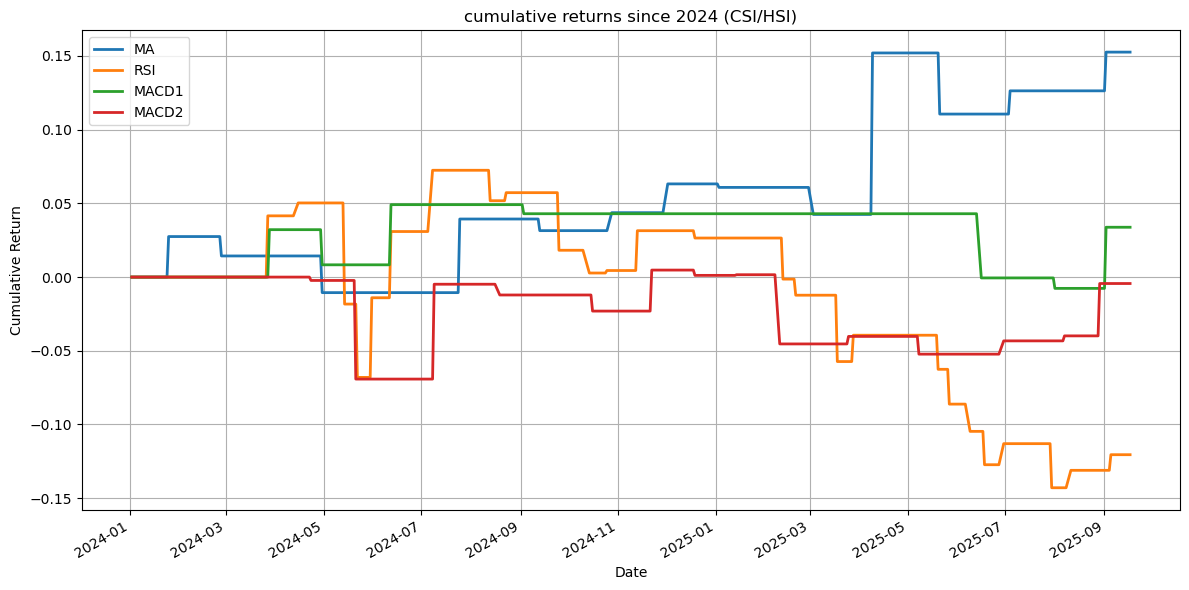

,MA,RSI,MACD1,MACD2
annual_return,0.093459,-0.07972,0.01911,-0.006871
sharpe,0.844687,-0.635929,0.289442,-0.075315
expon_sharpe,0.670693,-0.832313,0.071127,-0.26591
trade_sharpe,0.316898,-0.150639,0.154856,-0.010106
long_sharpe,17.300166,20.756596,116.684743,14.15583
sortino,0.431141,-0.279542,0.075545,-0.006809
omega,2.411854,0.698812,1.419291,0.970914
avg_long_holding_period,23.230769,15.692308,17.714286,19.642857
long_hits,13,26,7,14
long_hitrate,0.538462,0.461538,0.428571,0.5


Correlation with CSI returns since 2024:
MA:     0.011
RSI:    -0.033
MACD1:  0.015
MACD2:  0.007


In [6]:
# testing for 2024 onwards
# the MA strategy seems to work well for 5y but the rest work better in the past 1.5y

filtered_start_date = pd.Timestamp("2024-01-01")
filtered_index = normalized_prices.index[normalized_prices.index >= filtered_start_date]
ratio_prices_filtered = (normalized_prices.loc[filtered_index, 'CSI'] / normalized_prices.loc[filtered_index, 'HSI'])

def run_signal_backtest(signal_series, price_series, lag=0, holding_period=15, label='signal'):
    signal = signal_series.shift(lag).fillna(0).astype(int)
    signal = signal.loc[price_series.index]

    returns = pd.Series(0, index=price_series.index, dtype=float)
    trades = []

    for date in signal.index:
        if signal.loc[date] == 1:
            entry_date = date
            try:
                exit_idx = signal.index.get_loc(entry_date) + holding_period
                if exit_idx >= len(price_series):
                    continue
                exit_date = signal.index[exit_idx]
                entry_price = price_series.loc[entry_date]
                exit_price = price_series.loc[exit_date]
                ret = exit_price / entry_price - 1
                returns.loc[exit_date] += ret
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'return': ret,
                    'side': 'long'
                })
            except Exception:
                continue

    return returns, trades

# filtering signal series, running back tests
ma_signal_filtered = ma_crossover_signal.loc[filtered_index]
rsi_signal_filtered = rsi_signal.loc[filtered_index]
macd1_signal_filtered = condition_1_signal.loc[filtered_index]
macd2_signal_filtered = condition_2_signal.loc[filtered_index]

ma_returns, ma_trades = run_signal_backtest(ma_signal_filtered, ratio_prices_filtered, lag=2, holding_period=15, label='MA')
rsi_returns, rsi_trades = run_signal_backtest(rsi_signal_filtered, ratio_prices_filtered, lag=1, holding_period=10, label='RSI')
macd1_returns, macd1_trades = run_signal_backtest(macd1_signal_filtered, ratio_prices_filtered, lag=1, holding_period=12, label='MACD1')
macd2_returns, macd2_trades = run_signal_backtest(macd2_signal_filtered, ratio_prices_filtered, lag=1, holding_period=12, label='MACD2')

plt.figure(figsize=(12, 6))
ma_returns.cumsum().plot(label='MA', lw=2)
rsi_returns.cumsum().plot(label='RSI', lw=2)
macd1_returns.cumsum().plot(label='MACD1', lw=2)
macd2_returns.cumsum().plot(label='MACD2', lw=2)
plt.title("cumulative returns since 2024 (CSI/HSI)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def generate_performance_summary(returns: pd.Series, trades: list, positions: pd.Series = None):
    annual_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility else np.nan
    expon_sharpe = (
        returns.ewm(span=60).mean() / returns.ewm(span=60).std()
    ).mean() * np.sqrt(252)

    trade_returns = [t['return'] for t in trades]
    trade_sharpe = np.mean(trade_returns) / np.std(trade_returns) if len(trade_returns) > 1 and np.std(trade_returns) > 0 else np.nan

    long_returns = returns[returns > 0]
    long_sharpe = long_returns.mean() / long_returns.std() * np.sqrt(252) if len(long_returns) > 1 and long_returns.std() > 0 else np.nan

    downside = returns[returns < 0]
    sortino = returns.mean() / downside.std() * np.sqrt(252) if downside.std() else np.nan

    threshold = 0
    gain = (returns[returns > threshold] - threshold).sum()
    loss = (threshold - returns[returns < threshold]).sum()
    omega = gain / loss if loss else np.nan

    long_trades = [t for t in trades if t['side'] == 'long']
    avg_long_holding_period = np.mean([(t['exit_date'] - t['entry_date']).days for t in long_trades]) if long_trades else np.nan
    long_hits = sum(t['return'] > 0 for t in long_trades)
    long_hitrate = long_hits / len(long_trades) if long_trades else np.nan

    total_days = (returns.index[-1] - returns.index[0]).days
    years = total_days / 365.25
    avg_trades_per_year = len(trades) / years if years > 0 else np.nan
    overall_hitrate = sum(t['return'] > 0 for t in trades) / len(trades) if trades else np.nan

    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = cum_returns / rolling_max - 1
    max_drawdown = drawdowns.min()
    end_date = drawdowns.idxmin()
    start_date = cum_returns.loc[:end_date].idxmax()
    drawdown_period = f"{start_date.strftime('%d-%b-%y')} to {end_date.strftime('%d-%b-%y')} ({(end_date - start_date).days} days)"
    ann_return_to_drawdown = annual_return / abs(max_drawdown) if max_drawdown else np.nan
    pct_positive_days = (returns > 0).mean() * 100

    max_losing_streak = 0
    streak = 0
    for r in returns:
        if r < 0:
            streak += 1
            max_losing_streak = max(max_losing_streak, streak)
        else:
            streak = 0

    results = {
        'annual_return': annual_return,
        'sharpe': sharpe,
        'expon_sharpe': expon_sharpe,
        'trade_sharpe': trade_sharpe,
        'long_sharpe': long_sharpe,
        'sortino': sortino,
        'omega': omega,
        'avg_long_holding_period': avg_long_holding_period,
        'long_hits': len(long_trades),
        'long_hitrate': long_hitrate,
        'avg_trades_per_year': avg_trades_per_year,
        'overall_hitrate': overall_hitrate,
        'max_drawdown': max_drawdown,
        'max_drawdown_period': drawdown_period,
        'ann_return_to_drawdown': ann_return_to_drawdown,
        'pct_positive_days': pct_positive_days,
        'max_losing_streak': max_losing_streak
    }

    return pd.DataFrame(results, index=["CSI/HSI"])

# Summaries
summary_ma = generate_performance_summary(ma_returns, ma_trades).rename(index={"CSI/HSI": "MA"})
summary_rsi = generate_performance_summary(rsi_returns, rsi_trades).rename(index={"CSI/HSI": "RSI"})
summary_macd1 = generate_performance_summary(macd1_returns, macd1_trades).rename(index={"CSI/HSI": "MACD1"})
summary_macd2 = generate_performance_summary(macd2_returns, macd2_trades).rename(index={"CSI/HSI": "MACD2"})

summary_all = pd.concat([summary_ma, summary_rsi, summary_macd1, summary_macd2])
display(summary_all.T)

normalized_prices['CSI_ret'] = normalized_prices['CSI'].pct_change()
csi_ret_filtered = normalized_prices['CSI_ret'].loc[filtered_index]

print("Correlation with CSI returns since 2024:")
print(f"MA:     {ma_returns.corr(csi_ret_filtered):.3f}")
print(f"RSI:    {rsi_returns.corr(csi_ret_filtered):.3f}")
print(f"MACD1:  {macd1_returns.corr(csi_ret_filtered):.3f}")
print(f"MACD2:  {macd2_returns.corr(csi_ret_filtered):.3f}")


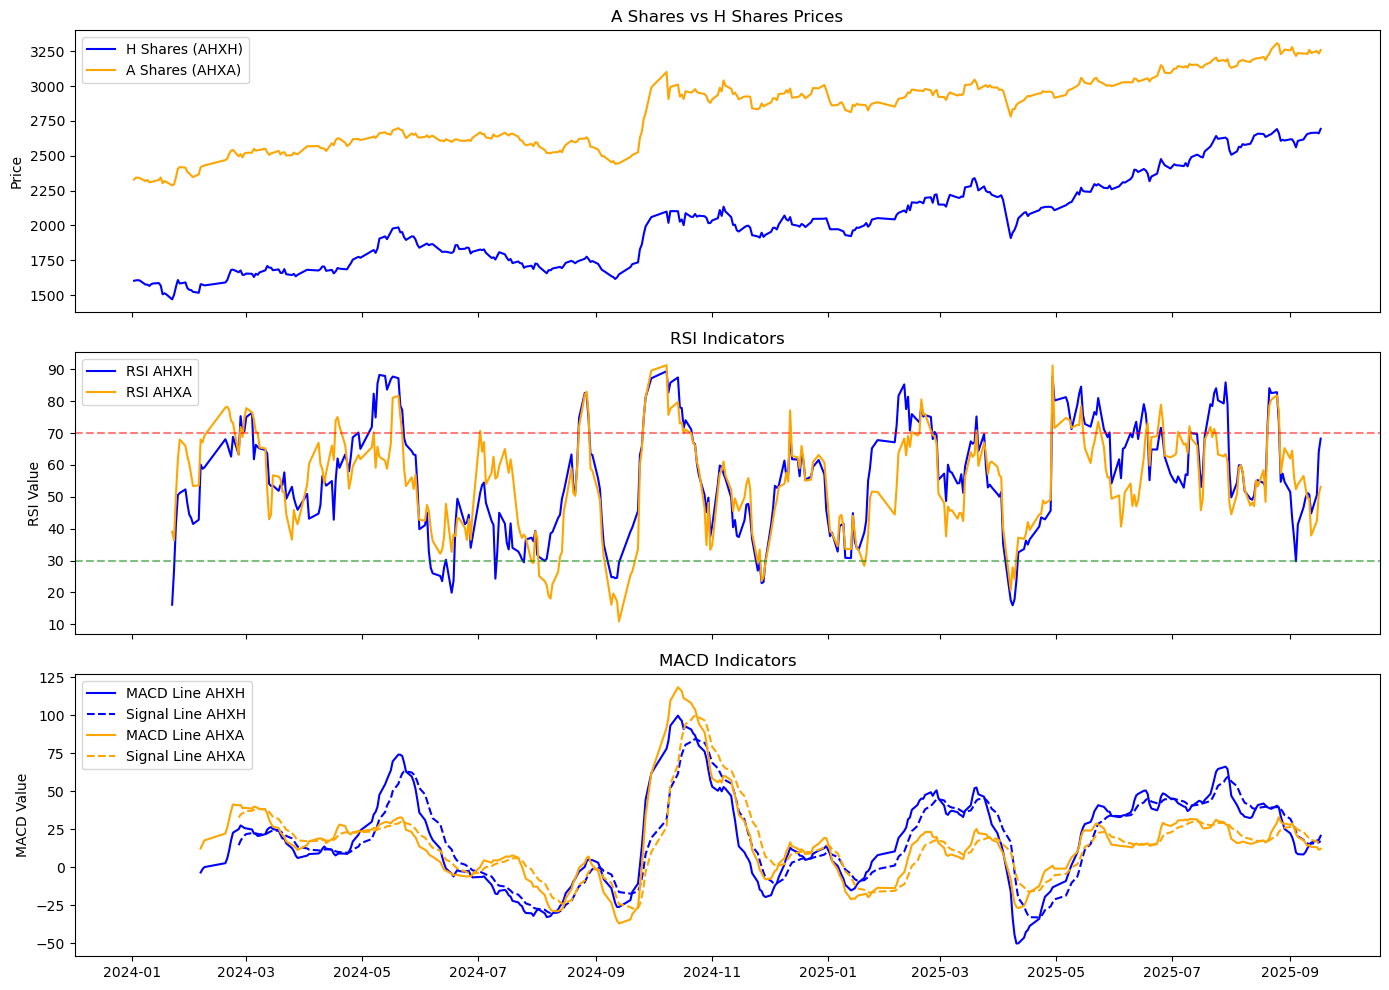

In [7]:
# plotting visualisations; A shares vs H shares, RSI indicators, MACD indicators

df_filtered = df[df.index >= pd.Timestamp("2024-01-01")]
rsi_ahxh = compute_rsi(df_filtered["AHXH"])
rsi_ahxa = compute_rsi(df_filtered["AHXA"])

macd_line_ahxh, signal_line_ahxh = compute_macd_lines(df_filtered["AHXH"])
macd_line_ahxa, signal_line_ahxa = compute_macd_lines(df_filtered["AHXA"])
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axs[0].plot(df_filtered.index, df_filtered["AHXH"], label="H Shares (AHXH)", color='blue')
axs[0].plot(df_filtered.index, df_filtered["AHXA"], label="A Shares (AHXA)", color='orange')
axs[0].set_title("A Shares vs H Shares Prices")
axs[0].set_ylabel("Price")
axs[0].legend()

axs[1].plot(rsi_ahxh.index, rsi_ahxh, label="RSI AHXH", color='blue')
axs[1].plot(rsi_ahxa.index, rsi_ahxa, label="RSI AHXA", color='orange')
axs[1].axhline(70, color='red', linestyle='--', alpha=0.5)
axs[1].axhline(30, color='green', linestyle='--', alpha=0.5)
axs[1].set_title("RSI Indicators")
axs[1].set_ylabel("RSI Value")
axs[1].legend()

axs[2].plot(macd_line_ahxh.index, macd_line_ahxh, label="MACD Line AHXH", color='blue')
axs[2].plot(signal_line_ahxh.index, signal_line_ahxh, label="Signal Line AHXH", color='blue', linestyle='--')
axs[2].plot(macd_line_ahxa.index, macd_line_ahxa, label="MACD Line AHXA", color='orange')
axs[2].plot(signal_line_ahxa.index, signal_line_ahxa, label="Signal Line AHXA", color='orange', linestyle='--')
axs[2].set_title("MACD Indicators")
axs[2].set_ylabel("MACD Value")
axs[2].legend()

plt.tight_layout()
plt.show()
